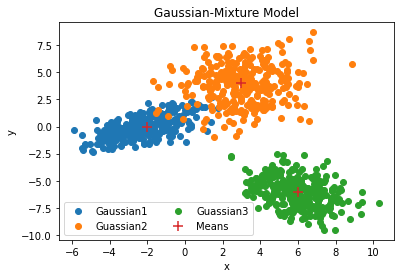

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import sys
import random


mean1 = [-2, 0]
cov1 = [[2, 0.9], [0.9, 1]]
data1 = np.random.multivariate_normal(mean1, cov1, 300)

mean2 = [3, 4]
cov2 = [[3, 0.1], [0.1, 3]]
data2 = np.random.multivariate_normal(mean2, cov2, 300)

mean3 = [6, -6]
cov3 = [[2, -1], [-1, 2]]
data3 = np.random.multivariate_normal(mean3, cov3, 300)

data = np.concatenate((data1, data2, data3), axis=0)
centers = np.asarray([mean1, mean2, mean3])

# Plot
fig1 = plt.scatter(data1[:, 0], data1[:, 1])
fig2 = plt.scatter(data2[:, 0], data2[:, 1])
fig3 = plt.scatter(data3[:, 0], data3[:, 1])
fig4 = plt.scatter(centers[:, 0], centers[:, 1], marker="+", s=100)
# plt.scatter(data[:, 0], data[:, 1])
plt.title('Gaussian-Mixture Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend((fig1, fig2, fig3, fig4),
           ('Gaussian1', 'Guassian2', 'Guassian3', 'Means'),
           scatterpoints=1,
           loc='lower left',
           ncol=2,
           fontsize=10)
plt.savefig('before_k_medoids.png')
plt.show()

In [5]:
# construct the similarity matrix
num = len(data)
similarity_matrix = np.zeros((num, num))

for i in range(0, num):
    for j in range(i+1, num):
        diff = data[i] - data[j]
        dist_tmp = np.linalg.norm(diff)
        similarity_matrix[i][j] = dist_tmp
        similarity_matrix[j][i] = dist_tmp

similarity_matrix = torch.from_numpy(similarity_matrix)

In [6]:
def k_medoids(similarity_matrix, k):
    
    # Step 1: Select initial medoids
    num = len(similarity_matrix)
    row_sums = torch.sum(similarity_matrix, dim=1)
    normalized_sim = similarity_matrix.T / row_sums
    normalized_sim = normalized_sim.T
    priority_scores = -torch.sum(normalized_sim, dim=0)
    values, indices = priority_scores.topk(k)
    
    tmp = -similarity_matrix[:, indices]
    tmp_values, tmp_indices = tmp.topk(1, dim=1)
    min_distance = -torch.sum(tmp_values)
    cluster_assignment = tmp_indices.resize_(num)
    print(min_distance)
    
    # Step 2: Update medoids
    for i in range(k):
        sub_indices = (cluster_assignment == i).nonzero()
        sub_num = len(sub_indices)
        sub_indices = sub_indices.resize_(sub_num)
        sub_similarity_matrix = torch.index_select(similarity_matrix, 0, sub_indices)
        sub_similarity_matrix = torch.index_select(sub_similarity_matrix, 1, sub_indices)
        sub_row_sums = torch.sum(sub_similarity_matrix, dim=1)
        sub_medoid_index = torch.argmin(sub_row_sums)
        # update the cluster medoid index
        indices[i] = sub_indices[sub_medoid_index]
        
    # Step 3: Assign objects to medoids
    tmp = -similarity_matrix[:, indices]
    tmp_values, tmp_indices = tmp.topk(1, dim=1)
    total_distance = -torch.sum(tmp_values)
    cluster_assignment = tmp_indices.resize_(num)
    print(total_distance)
        
    while (total_distance < min_distance):
        min_distance = total_distance
        # Step 2: Update medoids
        for i in range(k):
            sub_indices = (cluster_assignment == i).nonzero()
            sub_num = len(sub_indices)
            sub_indices = sub_indices.resize_(sub_num)
            sub_similarity_matrix = torch.index_select(similarity_matrix, 0, sub_indices)
            sub_similarity_matrix = torch.index_select(sub_similarity_matrix, 1, sub_indices)
            sub_row_sums = torch.sum(sub_similarity_matrix, dim=1)
            sub_medoid_index = torch.argmin(sub_row_sums)
            # update the cluster medoid index
            indices[i] = sub_indices[sub_medoid_index]

        # Step 3: Assign objects to medoids
        tmp = -similarity_matrix[:, indices]
        tmp_values, tmp_indices = tmp.topk(1, dim=1)
        total_distance = -torch.sum(tmp_values)
        cluster_assignment = tmp_indices.resize_(num)
        print(total_distance)
        
    return indices

tensor(4639.0377, dtype=torch.float64)
tensor(1657.7306, dtype=torch.float64)
tensor(1599.6259, dtype=torch.float64)
tensor(1598.3199, dtype=torch.float64)
tensor(1598.3199, dtype=torch.float64)


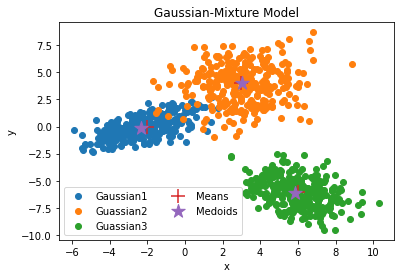

In [7]:
indices = k_medoids(similarity_matrix, k=3)
medoids = []
for i in range(3):
    medoids.append(data[indices[i]])

medoids = np.asarray(medoids)
fig1 = plt.scatter(data1[:, 0], data1[:, 1])
fig2 = plt.scatter(data2[:, 0], data2[:, 1])
fig3 = plt.scatter(data3[:, 0], data3[:, 1])
fig4 = plt.scatter(centers[:, 0], centers[:, 1], marker="+", s=200)
fig5 = plt.scatter(medoids[:, 0], medoids[:, 1], marker="*", s=200)
plt.title('Gaussian-Mixture Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend((fig1, fig2, fig3, fig4, fig5),
           ('Gaussian1', 'Guassian2', 'Guassian3', 'Means', 'Medoids'),
           scatterpoints=1,
           loc='lower left',
           ncol=2,
           fontsize=10)
plt.savefig('after_k_medoids.png')
plt.show()